# Handwriting Latex Calculator - Gulkaran Singh

Write a mathematical expression into the GUI to convert it into Latex and evaluate it in real time! Using the CROHME dataset, this software uses machine learning and a convolutional neural network to parse images to the correct Latex format.

Here are the imports needed for this project:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import layers, models

## Creating the Dataset

Let's create our dataset using a Keras utility. We will load our dataset with some parameters and a validation split of 80% training and 20% testing/validation.

In [2]:
data_directory = 'dataset/images'

image_height, image_width = 45, 45

# creates a training tensorflow dataset (80% split)
training_dataset = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(image_height, image_width)
)

# creates a testing/validation tensorflow dataset (20% split)
testing_dataset = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(image_height, image_width)
)

# generates the class names of the datasets
class_names = training_dataset.class_names
print(class_names)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.
Found 375974 files belonging to 82 classes.
Using 75194 files for validation.
['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


## Plotting the Dataset

With &nbsp;```matplotlib.pyplot```&nbsp; we can visualize the data and their respective class names. Here is a 5x5 sample size:

2022-12-26 20:29:33.897872: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


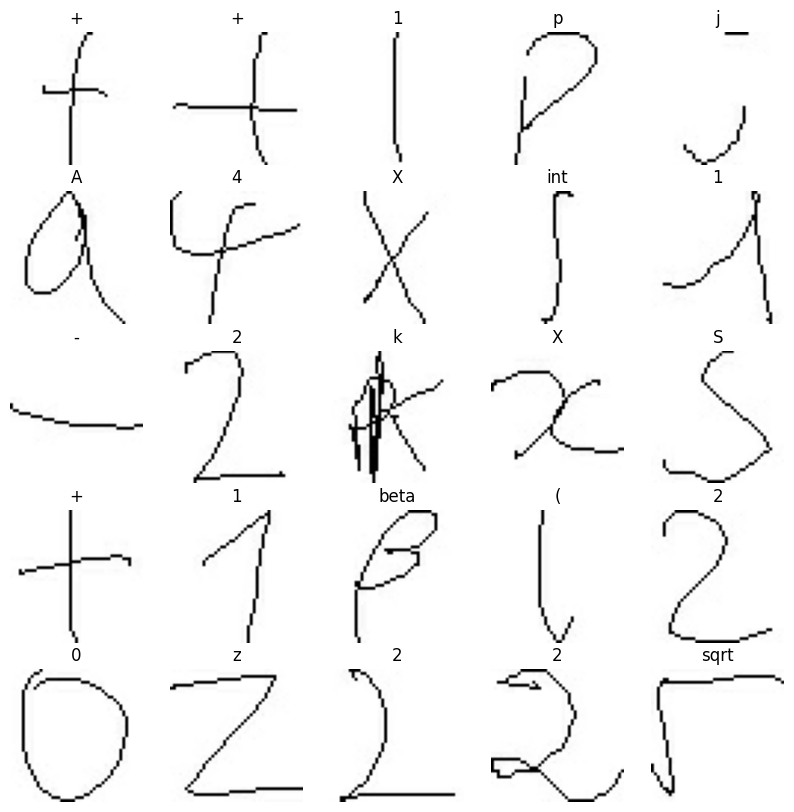

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

## Converting to Numpy Array

With our usage of &nbsp;```keras.utils```&nbsp; to convert our images into type &nbsp;```BatchDataset```&nbsp;. It would be more useful if we convert these Batch Datasets into Numpy arrays using the ```.numpy()```&nbsp;method. We can also normalize/standardize the data as each image has RGB channel values from 0-255. It would be more ideal for the range to be smaller (e.g 0-1) for computation benefits.

In [3]:
# converting training dataset
for image_batch, labels_batch in training_dataset:
  training_images, training_labels = image_batch.numpy(), labels_batch.numpy()
  break

# converting testing dataset
for image_batch, labels_batch in testing_dataset:
  testing_images, testing_labels = image_batch.numpy(), labels_batch.numpy()
  break

# normalize the pixel values to be between 0 and 1
training_images, training_labels = training_images / 255.0, training_labels / 255.0

2022-12-28 19:33:18.063198: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Now lets try visualizing the a certain image at a given index after we've normalized the data.

Explaining the 4th line in this code (```plt.title(...)```):
* ```training_labels[image_index]```&nbsp;typically would return an integer from 0-255 but since we've normalized the data it now returns a numpy float. If we simply rescale this value by 255, we get the expected index our class_name list should've received. It is now just in type &nbsp;```float```&nbsp; so we convert it to an integer with &nbsp;```int()```.

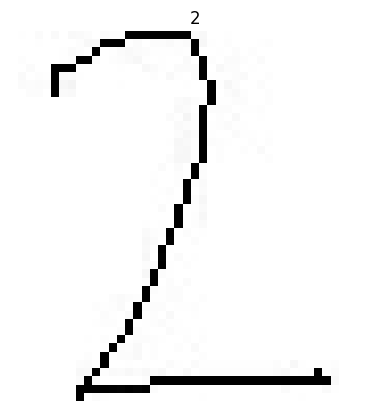

In [4]:
# attempt to visualize a single picture at a given index
image_index = 11
plt.imshow(training_images[image_index], cmap=plt.cm.binary)
plt.title(class_names[int(training_labels[image_index] * 255)])
plt.axis('off')
plt.show()

## Creating our Model

With all that initial setup, we can finally create our model! The typical architecture for a convolutional neural network (CNN) is a stack of 2D Convolution layers and 2D Pooling layers that provide the &nbsp;```max```&nbsp; pooling operation. These layers will extract certain features from the image which can be provided to a dense layer to attempt to classify the image based on the features found.

In [5]:
# creating our sequential model frame
model = models.Sequential()

# creating our convolutional base
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(45, 45, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# creating our dense layers
model.add(layers.Flatten())
model.add(layers.Dense(448, activation='relu'))
model.add(layers.Dense(len(class_names)))

# renaming and compiling
model._name='handwriting_model'

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [6]:
model.summary()

Model: "handwriting_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 43, 43, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 448)         

## Training the Model

Now our model is complete, we can train our model and how well it preforms.

In [13]:
history = model.fit(training_dataset,
  validation_data=testing_dataset,
  epochs=3, batch_size=128)

Epoch 1/3
9400/9400 [==============================] - 183s 19ms/step - loss: 0.4790 - accuracy: 0.8772 - val_loss: 0.2764 - val_accuracy: 0.9149
Epoch 2/3
9400/9400 [==============================] - 184s 20ms/step - loss: 0.1994 - accuracy: 0.9377 - val_loss: 0.1779 - val_accuracy: 0.9438
Epoch 3/3
9400/9400 [==============================] - 187s 20ms/step - loss: 0.1345 - accuracy: 0.9572 - val_loss: 0.1306 - val_accuracy: 0.9618


## Testing the Model

Now, we'll evaluate the models preformance on images its never seen before (testing dataset)

In [7]:
testing_loss, testing_accuracy = model.evaluate(testing_images, testing_labels, verbose=2)
print(testing_accuracy)

1/1 - 0s - loss: 43.2982 - accuracy: 0.0000e+00
0.0


## Visualizing our Results

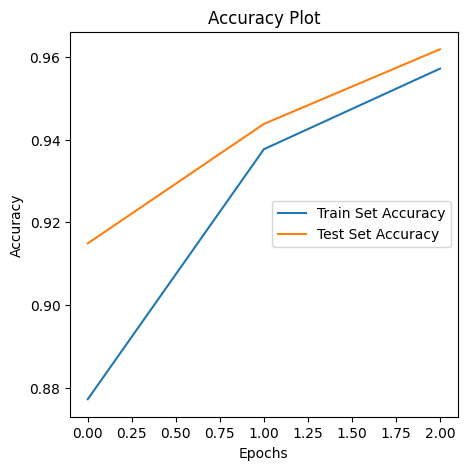

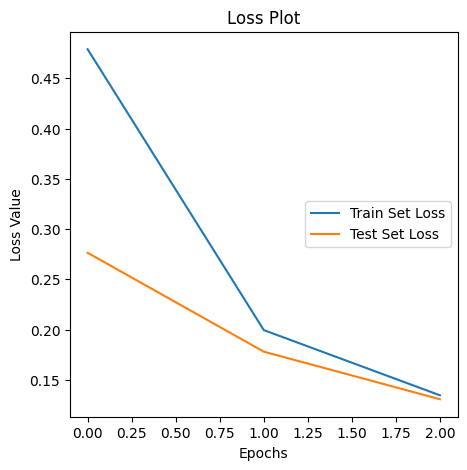

In [15]:
figure = plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Train Set Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Train Set Loss')
plt.plot(history.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='center right')
plt.show()

## Predictions

Similarly to last time, lets give our model a random image index, but this time have the model predict the correct answer.

1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
<class 'numpy.ndarray'>


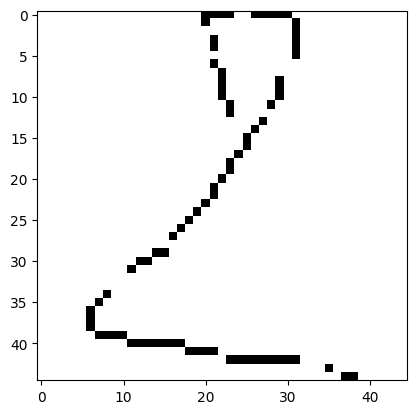

In [13]:
model = tf.keras.models.load_model('models')

image_index = 9

predictions = model.predict(testing_images)
print(class_names[np.argmax(predictions[image_index])])
print(type(testing_images))
plt.figure()
plt.imshow(testing_images[image_index])
plt.grid(False)
plt.show()

## Saving the Model

In [19]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [20]:
model.save_weights('weights')